In [228]:
from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

{'Cell': {'cm_config': {'lineNumbers': False}},
 'CodeCell': {'cm_config': {'autoCloseBrackets': False}},
 'Notebook': {'Header': False, 'Toolbar': False}}

# Importing

In [229]:
import numpy as np
import pandas as pd

# For rotatable 3D plot
#%matplotlib notebook

# For regular plot
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats import boxcox

from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier

from sklearn.metrics import roc_curve, log_loss

from keras.callbacks import EarlyStopping 
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam, SGD

# Data preparation

## Read raw data

In [237]:
model_data = pd.read_csv("9db113a1-cdbe-4b1c-98c2-11590f124dd8.csv", index_col=0)
real_data = pd.read_csv("5c9fa979-5a84-45d6-93b9-543d1a0efc41.csv", index_col=0)

model_data = model_data.drop(columns='Total Volume Donated (c.c.)')  # This is just 250 times Number of Donations
real_data = real_data.drop(columns='Total Volume Donated (c.c.)')
new_colnames = dict(zip(model_data.columns, ['MsL', 'NoD', 'MsF', 'Made']))
model_data = model_data.rename(new_colnames, axis="columns")
real_data = real_data.rename(new_colnames, axis="columns")

X = model_data.drop(columns='Made')
y = model_data['Made']
X_real = real_data
model_data

,MsL,NoD,MsF,Made
619,2,50,98,1
664,0,13,28,1
441,1,16,35,1
160,2,20,45,1
358,1,24,77,0
335,4,4,4,0
47,2,7,14,1
164,1,12,35,0
736,5,46,98,1
436,0,3,4,0


In [238]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 576 entries, 619 to 74
Data columns (total 4 columns):
MsL     576 non-null int64
NoD     576 non-null int64
MsF     576 non-null int64
Made    576 non-null int64
dtypes: int64(4)
memory usage: 22.5 KB


## New features

In [239]:
# Average time between donations (donation rate)
# Commitment (Good: donates since many months, donates recently too)
# Difference (Good: big), similar to commitment
# NOTE: These did not help much...

#X['Rate'] = (X['MsF'] - X['MsL']) / X['NoD'] + 0.001
#X['Cmtd'] = np.maximum(X['MsL'] / X['MsF'], 1/1000)  # We do not want zeros
#X['Diff'] = np.log(X['MsF'] - X['MsL'] + 1.001)

#X_real['Rate'] = (X_real['MsF'] - X_real['MsL']) / X_real['NoD']
#X_real['Cmtd'] = np.maximum(X_real['MsL'] / X_real['MsF'], 1/1000)  # We do not want zeros
#X_real['Diff'] = np.log(X_real['MsF'] - X_real['MsL'] + 1.001)

## Box-Cox transformation

In [240]:
X = X + 0.00001
X_real = X_real + 0.00001
X = pd.concat([pd.Series(boxcox(X.iloc[:, x])[0], index=X.index, name=X.columns[x]) for x in range(X.shape[1])], axis=1) 
X_real = pd.concat([pd.Series(boxcox(X_real.iloc[:, x])[0], index=X_real.index, name=X_real.columns[x]) for x in range(X_real.shape[1])], axis=1) 

## Interactions

In [241]:
# Note: This did not help much

# Interaction features
poly = PolynomialFeatures(degree=2, interaction_only=True)
poly.fit(X, y)
#X = pd.DataFrame(poly.transform(X), index=X.index)
poly.fit(X_real, y)
#X_real = pd.DataFrame(poly.transform(X_real), index=X_real.index)

PolynomialFeatures(degree=2, include_bias=True, interaction_only=True)

## Scaling

In [242]:
# Scaling
scaler = RobustScaler()
scaler.fit(X, y)
X = pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)
scaler.fit(X_real)
X_real = pd.DataFrame(scaler.transform(X_real), index=X_real.index, columns=X_real.columns)

# EDA

## Visualize scatter plots in matrix.

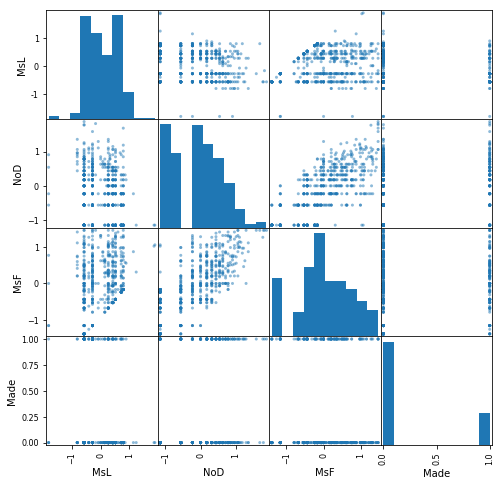

In [243]:
full_data = pd.concat([X, y], axis=1)
ax = pd.plotting.scatter_matrix(full_data, figsize=(8, 8))

## Correlation

In [244]:
full_data.corr()

,MsL,NoD,MsF,Made
MsL,1.000000,-0.188706,0.252586,-0.277250
NoD,-0.188706,1.000000,0.712147,0.240538
MsF,0.252586,0.712147,1.000000,-0.009530
Made,-0.277250,0.240538,-0.009530,1.000000


## Box plot of features

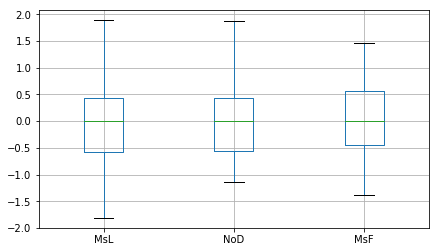

In [245]:
X.boxplot(figsize=(7, 4))

## 3D plot of original features

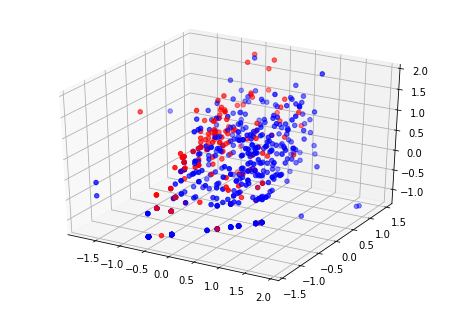

In [246]:
fig = plt.figure()
ax = Axes3D(fig)

x1 = X['MsL']
x2 = X['MsF']
x3 = X['NoD']
color = y
ax.scatter(x1, x2, x3, c=color, cmap='bwr')
plt.show()

# Models

## Simple feed forward neural network model

In [247]:
input_num = X.shape[1]

early = EarlyStopping(patience=2)
optimizer = Adam(lr=0.01, decay=0.1, amsgrad=False)

model_nn = Sequential()
model_nn.add(Dense(60, activation='relu', input_shape=(input_num,)))
model_nn.add(Dense(30, activation='relu'))
model_nn.add(Dense(15, activation='relu'))
model_nn.add(Dense(5, activation='relu'))
model_nn.add(Dense(1, activation='sigmoid'))
model_nn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model_nn.fit(X, y, epochs=40, validation_split=0.3, callbacks=[], batch_size=10)

Train on 403 samples, validate on 173 samples
Epoch 1/40
403/403 [==============================] - 2s 5ms/step - loss: 0.5480 - acc: 0.7370 - val_loss: 0.4378 - val_acc: 0.8150
Epoch 2/40
403/403 [==============================] - 0s 352us/step - loss: 0.4983 - acc: 0.7395 - val_loss: 0.4211 - val_acc: 0.8092
Epoch 3/40
403/403 [==============================] - 0s 346us/step - loss: 0.4908 - acc: 0.7717 - val_loss: 0.4200 - val_acc: 0.8439
Epoch 4/40
403/403 [==============================] - 0s 254us/step - loss: 0.4876 - acc: 0.7692 - val_loss: 0.4193 - val_acc: 0.8555
Epoch 5/40
403/403 [==============================] - 0s 237us/step - loss: 0.4859 - acc: 0.7767 - val_loss: 0.4175 - val_acc: 0.8555
Epoch 6/40
403/403 [==============================] - 0s 252us/step - loss: 0.4837 - acc: 0.7792 - val_loss: 0.4188 - val_acc: 0.8497
Epoch 7/40
403/403 [==============================] - ETA: 0s - loss: 0.4649 - acc: 0.807 - 0s 242us/step - loss: 0.4830 - acc: 0.7841 - val_loss: 0.417

In [248]:
# Predict real data
y_pred = model_nn.predict_proba(X_real)

In [249]:
# Prepare submission
df_submit = pd.DataFrame(y_pred, index=X_real.index, columns=['Made Donation in March 2007'])
df_submit.to_csv("result_nn.csv")

# Classic models

In [250]:
model1 = SVC(probability=True, kernel='rbf', random_state=42)
model2 = SVC(probability=True, kernel='linear', random_state=42)
model3 = LogisticRegression(penalty='l1', C=0.1)
model4 = SGDClassifier(loss='log', max_iter=1000, alpha=0.05, penalty='l2')
model5 = KNeighborsClassifier(n_neighbors=50)
model6 = XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.2, subsample = 0.3, learning_rate = 0.05,
                max_depth = 3, alpha = 1, gamma = 7, n_estimators = 60)

#param_grid = {'penalty': ['l1', 'l2'], 'alpha' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5]}
#grid_search = GridSearchCV(model, param_grid, cv=10, scoring='neg_log_loss')
#grid_search.fit(X, y)
#print(grid_search.best_params_)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = model1
steps = [
#    ('scale', scaler), 
    ('model', model)
]
pl = Pipeline(steps)

pl.fit(X_train, y_train)
y_pred_train = pl.predict_proba(X_train)

#score = -cross_val_score(pl, X, y, cv=5, scoring='neg_log_loss')
#print(np.mean(score), np.std(score))

print(log_loss(y_train, y_pred_train[:, 1]))

0.5032361255912053


In [251]:
# Predict real data
pl.fit(X, y)
y_pred = pl.predict_proba(X_real)

In [252]:
# Submit data
df_submit = pd.DataFrame(y_pred[:,1], index=X_real.index, columns=['Made Donation in March 2007'])
df_submit.to_csv("result_classic.csv")